In [583]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np 

In [584]:

import pandas as pd

year_range = [2021, 2022, 2023, 2024, 2025]

dfs = []

for year in year_range:
    base_url = f"https://www.espn.com/nba/salaries/_/year/{year}"
    
    for i in range(1, 15):
        url = base_url if i == 1 else f"{base_url}/page/{i}"
        tmp = pd.read_html(url)[0]
        tmp["year"] = year
        dfs.append(tmp)

tables = pd.concat(dfs, ignore_index=True)


In [585]:
df = tables.copy().dropna()
df 

,0,1,2,3,year
0,RK,NAME,TEAM,SALARY,2021
1,1,"Stephen Curry, G",Golden State Warriors,"$43,006,362",2021
2,2,"Russell Westbrook, G",Washington Wizards,"$41,358,814",2021
3,3,"Chris Paul, G",Phoenix Suns,"$41,358,814",2021
4,4,"James Harden, G",Brooklyn Nets,"$41,254,920",2021
...,...,...,...,...,...
2804,489,"Jordan Goodwin, G",Los Angeles Lakers,"$223,718",2025
2805,490,"Isaac Jones, C",Sacramento Kings,"$152,957",2025
2806,RK,NAME,TEAM,SALARY,2025
2807,491,"Drew Timme, F",Brooklyn Nets,"$113,055",2025


In [586]:
# When reading the HTML it included the repeated header row
# (RK, NAME, TEAM, SALARY) as an actual data row.
# Drop it by checking the literal header values in the name column.

# .ne(x) -> not equal to x  

df = df[df[1].astype(str).str.upper().ne("NAME")].copy()
df.sort_values(0)

,0,1,2,3,year
1,1,"Stephen Curry, G",Golden State Warriors,"$43,006,362",2021
1161,1,"Stephen Curry, G",Golden State Warriors,"$48,070,014",2023
613,1,"Stephen Curry, G",Golden State Warriors,"$45,780,966",2022
2268,1,"Stephen Curry, G",Golden State Warriors,"$55,761,216",2025
1743,1,"Stephen Curry, G",Golden State Warriors,"$51,915,615",2024
...,...,...,...,...,...
1268,99,"Brook Lopez, C",Milwaukee Bucks,"$13,906,976",2023
2375,99,"Bogdan Bogdanovic, G",LA Clippers,"$17,260,000",2025
720,99,"Taurean Prince, F",Minnesota Timberwolves,"$13,000,000",2022
1850,99,"P.J. Washington, F",Dallas Mavericks,"$16,847,826",2024


In [587]:
# Turn SALARY into int
s = df[3].astype(str).str.replace(r"[$,]", "", regex=True).str.strip()
df[3] = pd.to_numeric(s, errors="coerce").astype("Int64")  # nullable int
df.dropna(inplace=True)


In [588]:
names_df = pd.DataFrame({"names":df[df.columns[1]]})

allowed = set(names_df["names"].unique())  
allowed_df = pd.DataFrame(allowed)

df_filtered = names_df[names_df["names"].isin(allowed)]

assert len(names_df) == len(df_filtered)
allowed_df 

,0
0,"Allonzo Trier, G"
1,"Dennis Smith Jr., PG"
2,"Furkan Korkmaz, SG"
3,"Maurice Harkless, SF"
4,"Tyrell Terry, PG"
...,...
826,"Pacome Dadiet, F"
827,"T.J. Leaf, PF"
828,"Ja'Kobe Walter, G"
829,"James Wiseman, C"


In [589]:
allowed_df.to_csv("names_salaries_tmp.csv", index=False)


Text(0, 0.5, 'Salary (1e7 $)')

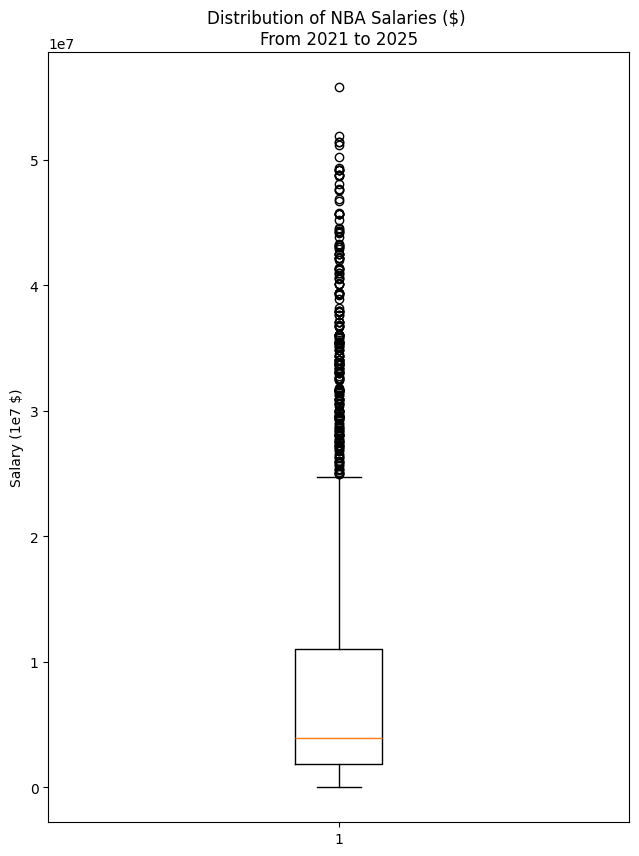

In [590]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 10))

ax.boxplot(df[3])
ax.set_title("Distribution of NBA Salaries ($) \nFrom 2021 to 2025")
ax.set_ylabel("Salary (1e7 $)")

In [591]:
import pandas as pd
import re
import unicodedata

_SUFFIXES = {"jr", "sr", "ii", "iii", "iv", "v"}

def norm_name(raw: str) -> str:
    s = unicodedata.normalize("NFKD", str(raw))
    s = "".join(ch for ch in s if not unicodedata.combining(ch))  # strip accents
    s = s.lower().strip()

    # normalize apostrophes / punctuation
    s = s.replace("’", "'")
    s = re.sub(r"[.\(\)]", "", s)

    # hyphens -> space, multiple spaces -> single
    s = s.replace("-", " ")
    s = re.sub(r"\s+", " ", s).strip()

    # remove commas etc
    s = s.replace(",", "")

    # drop suffixes at end
    parts = s.split()
    while parts and parts[-1] in _SUFFIXES:
        parts.pop()

    # normalize common "deandre"/"de'andre" patterns by removing apostrophe
    s = " ".join(parts).replace("de'andre", "deandre").replace("d'angelo", "dangelo")

    return s

dfA = pd.read_csv("names_advanced_tmp.csv") 
dfB = pd.read_csv("names_salaries_tmp.csv")   

# adjust these column names if needed:
colA_player = "Player"
colA_addl   = "Player-additional"
colB_name   = "0"

# Build normalized keys
dfA["_key"] = dfA[colA_player].map(norm_name)
dfB["_player_only"] = dfB[colB_name].astype(str).str.split(",").str[0].str.strip()
dfB["_key"] = dfB["_player_only"].map(norm_name)

# Lookup: normalized name -> list[(Player, Player-additional)]
a_lookup = (
    dfA.groupby("_key")[[colA_player, colA_addl]]
       .apply(lambda g: list(map(tuple, g.to_numpy())))
       .to_dict()
)


In [592]:
mapping = {}
missing = []

for bval, k in zip(dfB[colB_name], dfB["_key"]):
    if k in a_lookup:
        mapping[bval] = a_lookup[k]
    else:
        missing.append(bval)

print("matches:", len(mapping), "missing:", len(missing))
mapping

matches: 744 missing: 87


{'Dennis Smith Jr., PG': [('Dennis Smith Jr.', 'smithde03'),
  ('Dennis Smith Jr.', 'smithde03'),
  ('Dennis Smith Jr.', 'smithde03'),
  ('Dennis Smith Jr.', 'smithde03'),
  ('Dennis Smith Jr.', 'smithde03')],
 'Furkan Korkmaz, SG': [('Furkan Korkmaz', 'korkmfu01'),
  ('Furkan Korkmaz', 'korkmfu01'),
  ('Furkan Korkmaz', 'korkmfu01'),
  ('Furkan Korkmaz', 'korkmfu01')],
 'Maurice Harkless, SF': [('Maurice Harkless', 'harklma01'),
  ('Maurice Harkless', 'harklma01'),
  ('Maurice Harkless', 'harklma01')],
 'Tyrell Terry, PG': [('Tyrell Terry', 'terryty01'),
  ('Tyrell Terry', 'terryty01')],
 'Trae Young, G': [('Trae Young', 'youngtr01'),
  ('Trae Young', 'youngtr01'),
  ('Trae Young', 'youngtr01'),
  ('Trae Young', 'youngtr01'),
  ('Trae Young', 'youngtr01')],
 'Clint Capela, C': [('Clint Capela', 'capelca01'),
  ('Clint Capela', 'capelca01'),
  ('Clint Capela', 'capelca01'),
  ('Clint Capela', 'capelca01'),
  ('Clint Capela', 'capelca01')],
 'Al-Farouq Aminu, SF': [('Al-Farouq Aminu', '

In [593]:
for i in missing:
    print(i) 

Allonzo Trier, G
Dragan Bender, F
Josh Gray, G
Jonah Bolden, PF
Ky Bowman, G
Courtney Lee, G
Chris Clemons, G
Antonio Blakeney, G
Alex Abrines, G
Marcin Gortat, C
Isaiah Whitehead, G
Jason Smith, F
Omer Asik, C
Ike Anigbogu, C
Wade Baldwin IV, G
Omri Casspi, F
Dairis Bertans, G
Nate Williams, G
MarShon Brooks, G
Chandler Parsons, SF
Isaiah Taylor, G
Julyan Stone, G
Nikola Mirotic, F
Ben Moore, F
Tyler Lydon, F
Tyreke Evans, G
DaRon Holmes II, F
Rodney Purvis, G
Nick Young, G
Zhou Qi, C
Isaiah Canaan, G
Milos Teodosic, G
Miles Plumlee, C
Alexis Ajinca, C
Paul Zipser, F
Nigel Williams-Goss, G
Dwyane Wade, G
Manu Ginobili, G
Brandon Jennings, G
Timofey Mozgov, C
Jabari Bird, G
Luca Vildoza, G
Omari Rasulala Spellman, F
Jacob Evans, G
Dirk Nowitzki, F
Jimmer Fredette, G
Wilson Chandler, F
Dewan Hernandez, F
Malachi Richardson, G
Georgios Papagiannis, C
Marko Guduric, G
Jonathon Simmons, G
Tyler Zeller, C
Ryan Anderson, PF
Wesley Johnson, F
Dakari Johnson, C
Nene Hilario, C
Vince Carter, G


In [594]:
import hashlib

df["Player"] = df[1].map(lambda n: (mapping.get(n) or [(None, None)])[0][0])
df["Player-additional"] = df[1].map(lambda n: (mapping.get(n) or [(None, None)])[0][1])

In [595]:
df = df[["Player", "Player-additional", 2, 3, "year"]]
df = df.rename(columns={2:"Team", 3: "Salary", "year":"Year"})

df 

,Player,Player-additional,Team,Salary,Year
1,Stephen Curry,curryst01,Golden State Warriors,43006362,2021
2,Russell Westbrook,westbru01,Washington Wizards,41358814,2021
3,Chris Paul,paulch01,Phoenix Suns,41358814,2021
4,James Harden,hardeja01,Brooklyn Nets,41254920,2021
5,John Wall,walljo01,Houston Rockets,41254920,2021
...,...,...,...,...,...
2802,Kevin Knox,knoxke01,Golden State Warriors,263939,2025
2803,P.J. Tucker,tuckepj01,New York Knicks,246833,2025
2804,Jordan Goodwin,goodwjo01,Los Angeles Lakers,223718,2025
2805,Isaac Jones,jonesis01,Sacramento Kings,152957,2025


In [596]:
team_to_tm = {
    "Atlanta Hawks": "ATL",
    "Boston Celtics": "BOS",
    "Brooklyn Nets": "BRK",
    "Charlotte Hornets": "CHO",
    "Chicago Bulls": "CHI",
    "Cleveland Cavaliers": "CLE",
    "Dallas Mavericks": "DAL",
    "Denver Nuggets": "DEN",
    "Detroit Pistons": "DET",
    "Golden State Warriors": "GSW",
    "Houston Rockets": "HOU",
    "Indiana Pacers": "IND",
    "Los Angeles Lakers": "LAL",
    "LA Clippers": "LAC",
    "Memphis Grizzlies": "MEM",
    "Miami Heat": "MIA",
    "Milwaukee Bucks": "MIL",
    "Minnesota Timberwolves": "MIN",
    "New Orleans Pelicans": "NOP",
    "New York Knicks": "NYK",
    "Oklahoma City Thunder": "OKC",
    "Orlando Magic": "ORL",
    "Philadelphia 76ers": "PHI",
    "Phoenix Suns": "PHO",
    "Portland Trail Blazers": "POR",
    "Sacramento Kings": "SAC",
    "San Antonio Spurs": "SAS",
    "Toronto Raptors": "TOR",
    "Utah Jazz": "UTA",
    "Washington Wizards": "WAS",
}


In [597]:
df["Tm"] = df["Team"].map(team_to_tm) 
df = df.drop("Team", axis=1)

In [598]:
df = df[["Player", "Player-additional", "Tm", "Salary", "Year"]]
df.sort_values(["Player", "Year"]).head(25)

,Player,Player-additional,Tm,Salary,Year
2208,A.J. Green,greenaj01,MIL,1801769,2024
2672,A.J. Green,greenaj01,MIL,2120693,2025
2241,A.J. Lawson,lawsoaj01,DAL,1000000,2024
2668,A.J. Lawson,lawsoaj01,TOR,2120693,2025
1448,AJ Griffin,griffaj01,ATL,3536160,2023
2042,AJ Griffin,griffaj01,ATL,3712920,2024
2572,AJ Griffin,griffaj01,HOU,3889920,2025
2615,AJ Johnson,johnsaj01,WAS,2795294,2025
67,Aaron Gordon,gordoaa01,DEN,18136364,2021
694,Aaron Gordon,gordoaa01,DEN,16409091,2022


In [599]:
df = df.dropna()
df 

,Player,Player-additional,Tm,Salary,Year
1,Stephen Curry,curryst01,GSW,43006362,2021
2,Russell Westbrook,westbru01,WAS,41358814,2021
3,Chris Paul,paulch01,PHO,41358814,2021
4,James Harden,hardeja01,BRK,41254920,2021
5,John Wall,walljo01,HOU,41254920,2021
...,...,...,...,...,...
2802,Kevin Knox,knoxke01,GSW,263939,2025
2803,P.J. Tucker,tuckepj01,NYK,246833,2025
2804,Jordan Goodwin,goodwjo01,LAL,223718,2025
2805,Isaac Jones,jonesis01,SAC,152957,2025


In [600]:
df.to_csv("clean/nba_salaries_2021_to_2025.csv", index=False)